In [6]:
import balltracking.balltrack as blt
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


fwhm = 7
kernel = 'boxcar'
dims = [263, 263]
# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
step = fwhm
fov = np.s_[pad:-pad:step, pad:-pad:step]

In [8]:
# Load Balltrack velocities
datadir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')
b_top = np.load(os.path.join(datadir, 'balltrack/ballpos_top.npy'))
b_bot = np.load(os.path.join(datadir, 'balltrack/ballpos_bottom.npy'))
# Make velocity flow fields
tranges = [[0, nt] for nt in range(30, 81, 5)]
cal_top = 1.801
cal_bot = 1.713
bvxs, bvys = zip(*[blt.make_euler_velocity(b_top, b_bot, cal_top, cal_bot, dims, trange, fwhm, kernel) 
                   for trange in tranges])

In [49]:
vx_top, vy_top, wplane_top = blt.make_velocity_from_tracks(b_top, dims, tranges[0], fwhm, kernel)
vx_bot, vy_bot, wplane_bot = blt.make_velocity_from_tracks(b_bot, dims, tranges[0], fwhm, kernel)

In [14]:
# Load Stein data
svx_files = sorted(glob.glob(os.path.join(datadir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir,'SDO_vy*.fits')))
nframes = range(30, 81, 5)
tranges = [[0, nt] for nt in nframes]
#vx, vy = load_vel_mean((svx_files, svy_files), tranges[0])
vx_stein_l, vy_stein_l = zip(*[load_vel_mean((svx_files, svy_files), trange) for trange in tranges])
# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = zip(*[smooth_vel(vx, vy, fwhm, kernel='boxcar') for vx, vy in zip(vx_stein_l, vy_stein_l)])

In [15]:
# Calculate correlations between Stein and Balltracking
corrs = []
for i in range(len(tranges)):
    vx_stein = vx_stein_sm[i]
    vy_stein = vy_stein_sm[i]
    bvx = bvxs[i]
    bvy = bvys[i]
    corrs.append(calc_c_pearson(vx_stein, bvx, vy_stein, bvy, fov=fov))

In [65]:
# Load FLCT
from pathlib import Path
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi


vidx = 5
trange = [0,30]
datadir_flct = os.path.expanduser('~/Data/sanity_check/flct_results/')
lctfiles = sorted(list(Path(os.path.join(datadir_flct, 'Stein-simulation-series')).rglob('flct-km-Stein-simul-*.save')))
vx_flct = read_vi(lctfiles[vidx], 'vx') 
vy_flct = read_vi(lctfiles[vidx], 'vy')

vx_flct = vx_flct[trange[0]:trange[1], ...].mean(axis=0)
vy_flct = vy_flct[trange[0]:trange[1], ...].mean(axis=0)

c_flct = calc_c_pearson(vx_stein_sm[0], vx_flct, vy_stein_sm[0], vy_flct, fov=fov)
fp, fr, _, _, _ = np.polyfit(vx_flct[fov].ravel()*u, vx_stein_sm[0][fov].ravel(), 1, full=True)

fr = np.sqrt(fr[0]/npts)
print(fr)

317.2247986117975


In [69]:
u = 368000 / 60
npts = vx_stein_sm[0][fov].size
x = bvxs[0][fov].ravel()*u
y = vx_stein_sm[0][fov].ravel()

p, r, _, _, _ = np.polyfit(x, y, 1, full=True)

r1 = np.sqrt(r[0]/x.size)
norm22 = np.sum((p[0]*x + p[1] - y)**2)
#norm2 = np.linalg.norm(p[0]*x + p[1] - y)
r2 = np.sqrt(norm22/x.size)

print('r1 = ', r1)
print('r2 = ', r2)


r1 =  264.53655112759407
r2 =  264.53655112759424


In [67]:
# Calculate residuals RMSE
u = 368000 / 60
npts = vx_stein_sm[0][fov].size
bp, br, _, _, _ = np.polyfit(bvxs[0][fov].ravel()*u, vx_stein_sm[0][fov].ravel(), 1, full=True)
br = np.sqrt(br[0]/npts)
print('residuals (balltracking - both - calibrated) = ', br)

bp, br, _, _, _ = np.polyfit(vx_top[fov].ravel()*u, vx_stein_sm[0][fov].ravel(), 1, full=True)
br = np.sqrt(br[0]/npts)
print('residuals (balltracking - top) = ', br)


# RMSE_b_top = np.sqrt(np.mean((vx_stein_sm[0][fov] - vx_top[fov]*u*cal_top)**2))
# print('RMSE_b_top = ',  RMSE_b_top)

# RMSE_b_bot = np.sqrt(np.mean((vx_stein_sm[0][fov] - vx_bot[fov]*u*cal_bot)**2))
# print('RMSE_b_bot = ',  RMSE_b_bot)

# RMSE_f = np.sqrt(np.mean((vx_stein_sm[0][fov] - vx_flct[fov]*u)**2))
# print('RMSE_f = ', RMSE_f)

residuals (balltracking - both - calibrated) =  264.53655112759407
residuals (balltracking - top) =  302.2433497991878


<IPython.core.display.Javascript object>


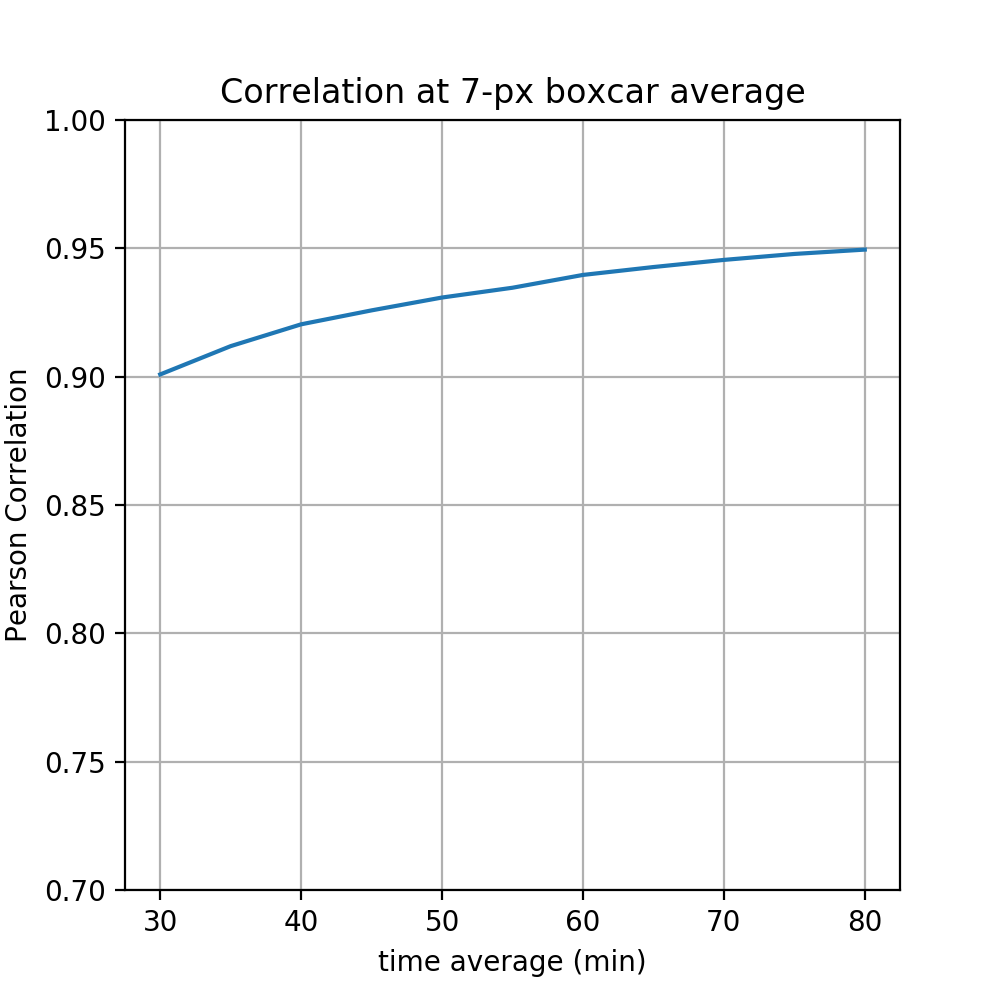

191.8912996418546


<IPython.core.display.Javascript object>


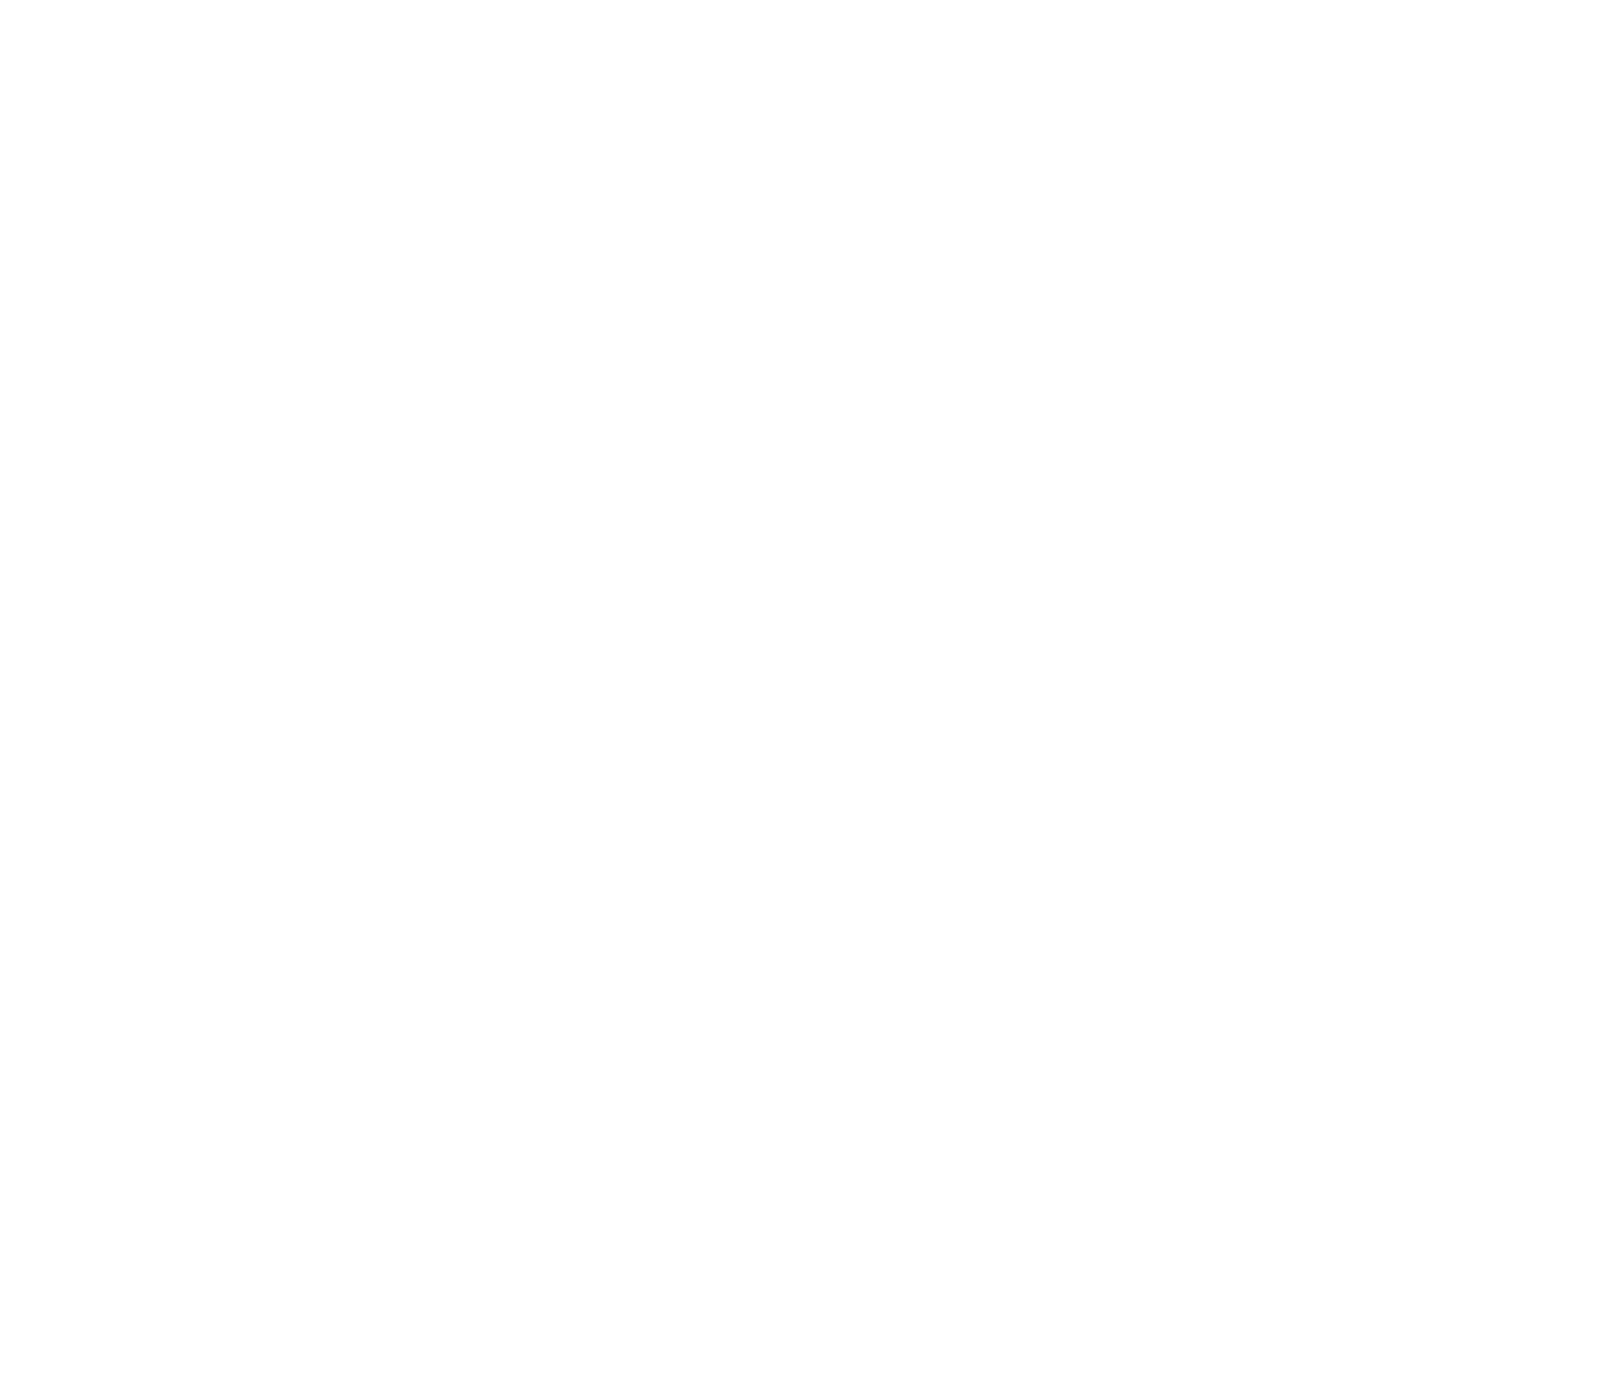

NameError: name 'vx_flct' is not defined

In [24]:
%matplotlib notebook

plt.figure(figsize=(8,7))
plt.scatter(vx_stein_sm[0][fov].ravel(), vx_flct[fov].ravel()*u, marker='+', color='black', alpha=0.7, label = '[C={:1.2f}] [RMSE={:1.0f} m/s]'.format(c_flct, fr))
plt.scatter(vx_stein_sm[0][fov].ravel(), bvxs[0][fov].ravel()*u, marker='+', color='orange', alpha=1.0, label = '[C={:1.2f}] [RMSE={:1.0f} m/s]'.format(corrs[0], br))
plt.axis([-2000, 2000, -2000, 2000])
plt.xlabel(r'$v_x$ (simulation) [m/s]')
plt.ylabel(r'$v_x$ (Balltracking) [m/s]')
plt.legend()

In [ ]:
%matplotlib notebook
plt.figure(figsize=(5,5))
plt.plot(nframes, corrs)
plt.title('Correlation at 7-px boxcar average')
plt.xlabel('time average (min)')
plt.ylabel('Pearson Correlation')
plt.ylim([0.7, 1.0])
plt.grid()